In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import requests


[[-3.35031385e+03  1.00000000e+00  1.70000000e+01]
 [ 3.25349434e+02  1.00000000e+00  1.70000000e+01]
 [ 2.63461059e+03  1.00000000e+00  1.70000000e+01]
 ...
 [ 4.48035533e+03  0.00000000e+00  2.10000000e+01]
 [-9.17782075e+03  0.00000000e+00  2.00000000e+01]
 [-2.62746316e+04  1.00000000e+00  1.90000000e+01]]


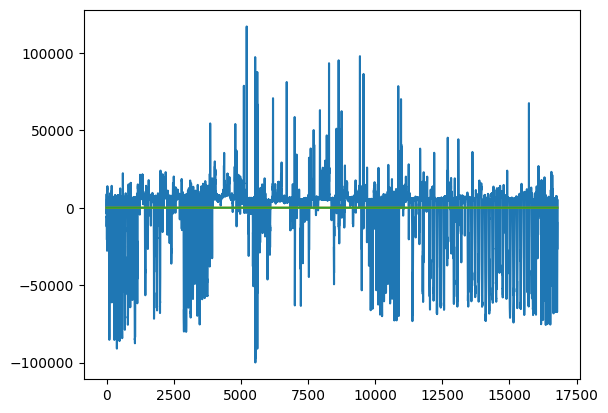

In [64]:
training_set_df = pd.read_csv("power_usage.csv")

training_set = training_set_df.iloc[:, 2:5].values
print(training_set)
training_set = [i for i in training_set if float(i[0]) > -100000]
plt.plot(training_set)
plt.show()

In [65]:
# How many hours? 6? So 6 hours is 36
seq_length = 36

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
print((len(training_set)))
# power_values = np.array([i[0] for i in training_set]).reshape(-1, 1)
training_data = sc.fit_transform(training_set)
# training_data = []
# for i, power_val in enumerate(power_values):
    # training_data.append([power_val, training_set[i][1], training_set[i][2]])

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
print(trainX.size())
print(trainY.size())

16786
torch.Size([11221, 36, 3])
torch.Size([11221, 3])


In [66]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=5):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.is_bidirectional = 2 if True else 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size * 3, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 3, hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 1)
        self.fc2 = nn.Linear(hidden_size * 1, num_classes)
        # self.fc3 = nn.Linear(hidden_size * 1, hidden_size // 2)
        # self.fc4 = nn.Linear(hidden_size // 2, num_classes)



    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers * self.is_bidirectional, x.size(0), self.hidden_size * 3)).to("cuda")
        c_0 = Variable(torch.zeros(self.num_layers * self.is_bidirectional, x.size(0), self.hidden_size * 3)).to("cuda")
        print(h_0.size())
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size * 3)
        out = self.fc(h_out)
        out = self.fc1(out)
        out = self.fc2(out)
        print(out.shape)
        # out = self.fc3(out)
        # out = self.fc4(out)

        return out


In [67]:
# num_epochs = 2000
# learning_rate = 0.01

# input_size = 1
# hidden_size = 2
# num_layers = 1
# num_classes = 1

# lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [68]:
# criterion = torch.nn.MSELoss()    
# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# early_stop = 50
# least_loss = np.inf
# # Train the model
# for epoch in range(num_epochs):
#     outputs = lstm(trainX)
#     optimizer.zero_grad()
    
#     # obtain the loss function
#     loss = criterion(outputs, trainY)
#     loss.backward()
#     optimizer.step()

#     if least_loss > loss.item():
#        least_loss = loss.item()
#        early_stop = 50
#     else:
#        early_stop -= 1
    
#     if epoch % 100 == 0:
#       print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
#     if early_stop <= 0:
#       print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))


In [69]:
# lstm.eval()
# train_predict = lstm(dataX)

# data_predict = train_predict.data.numpy()
# dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

# #Plot the Predictions
# plt.axvline(x=train_size, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [70]:
# '''
# Implement MSE calculation for the test data
# '''
# lstm.eval()
# test_predictions = lstm(testX)
# test_loss = criterion(test_predictions, testY)


# print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")


In [71]:
# # Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
# response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
# usage = response.json()
# ten_minute_averages = {"timestamp": [], "power": []}

# for i in range(0, len(usage['data']), 85):
#     values = usage['data'][i:i+120]
#     power = [value['power'] for value in values]
#     ten_minute_averages["timestamp"].append(values[0]['timestamp'])
#     ten_minute_averages["power"].append(np.average(power) * 1000)

# power = ten_minute_averages["power"]
# power = [[i] for i in power]
# power = np.array(power)

In [72]:
# power = sc.fit_transform(power)
# testNewX, testNewY = sliding_windows(power, seq_length)
# testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
# testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

# lstm.eval()
# test_predict = lstm(testDataX)

# data_predict = test_predict.data.numpy()
# dataY_test_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(testDataY)

# #Plot the Predictions
# plt.axvline(x=0, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [73]:
# # How many hours? 6? So 6 hours is 36
# seq_length = 36

# def sliding_windows(data, seq_length):
#     x = []
#     y = []

#     for i in range(len(data) - seq_length - 1):
#         _x = data[i:(i+seq_length)]
#         _y = data[i+seq_length]
#         x.append(_x)
#         y.append(_y)

#     return np.array(x), np.array(y)

# sc = MinMaxScaler()
# training_data = sc.fit_transform(training_set)

# x, y = sliding_windows(training_data, seq_length)

# train_size = int(len(y) * 0.67)
# test_size = len(y) - train_size

# dataX = Variable(torch.Tensor(np.array(x)))
# dataY = Variable(torch.Tensor(np.array(y)))

# trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
# trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
# testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [74]:
# num_epochs = 5000
# learning_rate = 0.01

# input_size = 1
# hidden_size = 2
# num_layers = 1
# num_classes = 1

# lstm_5000 = LSTM(num_classes, input_size, hidden_size, num_layers)

In [75]:
# criterion = torch.nn.MSELoss()    
# optimizer = torch.optim.Adam(lstm_5000.parameters(), lr=learning_rate)
# early_stop = 50
# least_loss = np.inf
# # Train the model
# for epoch in range(num_epochs):
#     outputs = lstm_5000(trainX)
#     optimizer.zero_grad()
    
#     # obtain the loss function
#     loss = criterion(outputs, trainY)
#     loss.backward()
#     optimizer.step()

#     if least_loss > round(loss.item(), 7):
#       #  print("Better!")
#       #  print(loss.item())
#       #  print(least_loss)
#        least_loss = round(loss.item(), 7)
#        early_stop = 50
#     else:
#        early_stop -= 1
    
#     if epoch % 100 == 0:
#       print("Epoch: %d, loss: %1.5f, early stop: %d" % (epoch, loss.item(), early_stop))
    
#     if early_stop <= 0:
#       print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))
#       break


In [76]:
# lstm_5000.eval()
# train_predict = lstm_5000(dataX)

# data_predict = train_predict.data.numpy()
# dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

# #Plot the Predictions
# plt.axvline(x=train_size, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [77]:
# '''
# Implement MSE calculation for the test data
# '''
# lstm_5000.eval()
# test_predictions = lstm_5000(testX)
# test_loss = criterion(test_predictions, testY)


# print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")

In [78]:
# # Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
# response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
# usage = response.json()
# ten_minute_averages = {"timestamp": [], "power": []}

# for i in range(0, len(usage['data']), 85):
#     values = usage['data'][i:i+120]
#     power = [value['power'] for value in values]
#     ten_minute_averages["timestamp"].append(values[0]['timestamp'])
#     ten_minute_averages["power"].append(np.average(power) * 1000)

# power = ten_minute_averages["power"]
# power = [[i] for i in power]
# power = np.array(power)

# power = sc.fit_transform(power)
# testNewX, testNewY = sliding_windows(power, seq_length)
# testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
# testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

# lstm_5000.eval()
# test_predict = lstm_5000(testDataX)

# data_predict = test_predict.data.numpy()
# dataY_test_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(testDataY)

# #Plot the Predictions
# plt.axvline(x=0, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [79]:
num_epochs = 2000
learning_rates = [0.1, 0.01, 0.001, 0.0001]
learning_rate = 0.01

input_size = 3
# hidden_size = 2
num_layers = 1
num_classes = 3

seq_lengths = [52, 58, 64, 70, 76, 82] # We did 5 previously
hidden_sizes = [8, 16, 32] # We did 2 previously
# fig, ax = plt.subplots(6, 5, figsize=(30, 30))
device = "cuda"
best_seq = 0
best_hidden_size = 0
best_lr = 0
lowest_loss = np.inf
for lr in learning_rates:
    for i, seq_length in enumerate(seq_lengths):
        for j, hidden_size in enumerate(hidden_sizes):
            print(f"Starting with a sequence length of {seq_length} and hidden_size of {hidden_size}")
            lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
            lstm = lstm.to(device)
            early_stop = 50
            least_loss = np.inf
            criterion = torch.nn.MSELoss()    
            optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

            # Train the model
            for epoch in range(num_epochs):
                trainX = trainX.to(device)
                trainY = trainY.to(device)
                outputs = lstm(trainX)
                optimizer.zero_grad()
                
                # obtain the loss function
                print(outputs.shape)
                print(trainY.shape)
                loss = criterion(outputs, trainY)
                loss.backward()
                optimizer.step()
                
                if least_loss > loss.item():
                    least_loss = loss.item()
                    early_stop = 50
                else:
                    early_stop -= 1

                if epoch % 100 == 0:
                    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
                
                if early_stop <= 0:
                    print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))
                    break

            lstm.eval()
            dataX = dataX.to(device)
            dataY = dataY.to(device)
            train_predict = lstm(dataX)

            data_predict = train_predict.cpu().data.numpy()
            dataY_plot = dataY.cpu().data.numpy()

            data_predict = sc.inverse_transform(data_predict)
            dataY_plot = sc.inverse_transform(dataY_plot)


            lstm.eval()
            testX = testX.to(device)
            testY = testY.to(device)
            test_predictions = lstm(testX)
            test_loss = criterion(test_predictions, testY)

            if test_loss.item() < lowest_loss:
                lowest_loss = test_loss
                best_seq = seq_length
                best_hidden_size = hidden_size
                best_lr = lr
            #Plot the Predictions
            # ax[i][j].axvline(x=train_size, c='r', linestyle='--')
            # ax[i][j].set_title(f"Loss: {round(test_loss.item(), 5)}, Seq_Length: {seq_length}, Hidden_Size: {hidden_size}")

            # ax[i][j].plot(dataY_plot)
            # ax[i][j].plot(data_predict)


# plt.suptitle('Time-Series Prediction')
# plt.show()
print(f"Best Loss: {lowest_loss} on sequence length {best_seq}, hidden size of {best_hidden_size} and learning rate of {best_lr}")

Starting with a sequence length of 52 and hidden_size of 8
torch.Size([2, 11221, 24])
torch.Size([22442, 3])
torch.Size([22442, 3])
torch.Size([11221, 3])


/home/waluigi/miniconda3/envs/pytorch38/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11221, 3])) that is different to the input size (torch.Size([22442, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (22442) must match the size of tensor b (11221) at non-singleton dimension 0

In [ ]:
# How many hours? 6? So 6 hours is 36
print(best_seq)
print(best_hidden_size)
print(best_lr)
device = "cuda"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x))).to(device)
dataY = Variable(torch.Tensor(np.array(y))).to(device)

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(device)
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(device)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).to(device)
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).to(device)
print(trainX.size())
print(trainY.size())

num_epochs = 5000

input_size = 3
hidden_size = best_hidden_size 
num_layers = 1
num_classes = 3

lstm = LSTM(num_classes, input_size, best_hidden_size, num_layers)
lstm = lstm.to(device)


82
8
0.1
torch.Size([11191, 82, 3])
torch.Size([11191, 3])


In [ ]:
criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm.parameters(), lr=best_lr)
early_stop = 50
least_loss = np.inf
# Train the model
for epoch in range(num_epochs):

   outputs = lstm(trainX)
   optimizer.zero_grad()
   
   # obtain the loss function
   loss = criterion(outputs, trainY)
   loss.backward()
   optimizer.step()

   if least_loss > loss.item():
      least_loss = loss.item()
      early_stop = 50
   else:
      early_stop -= 1
   
   if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
   
   if early_stop <= 0:
      print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))
      break


Epoch: 0, loss: 0.38891
Epoch: 100, loss: 0.01618
Epoch: 200, loss: 0.01207
Epoch: 300, loss: 0.01117
Epoch: 400, loss: 0.00956
Epoch: 500, loss: 0.01795
Epoch: 546, loss: 0.00964, best_loss: 0.00867


In [ ]:
# Old best loss: Epoch: 340, loss: 0.01094, best_loss: 0.00854


# criterion = torch.nn.MSELoss()    
# optimizer = torch.optim.Adam(lstm.parameters(), lr=best_lr)
# lstm.load_state_dict(torch.load("energy_usage_predictor.pth"))

In [ ]:
'''
Implement MSE calculation for the test data
'''
lstm.eval()
testX = testX.to(device)
testY = testY.to(device)
test_predictions = lstm(testX)
test_loss = criterion(test_predictions, testY)


print(f"Test Loss for model trained {epoch} epochs: {test_loss.item()}")

Test Loss for model trained 546 epochs: 0.01445331797003746


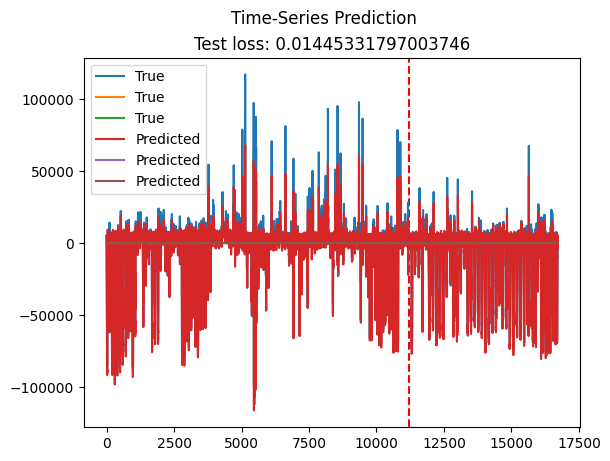

In [ ]:
lstm.eval()
dataX = dataX.to(device)
train_predict = lstm(dataX)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.cpu().data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#Plot the Predictions
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.title(f"Test loss: {test_loss.item()}")
plt.show()

In [ ]:
import datetime

torch.Size([82, 82, 3])


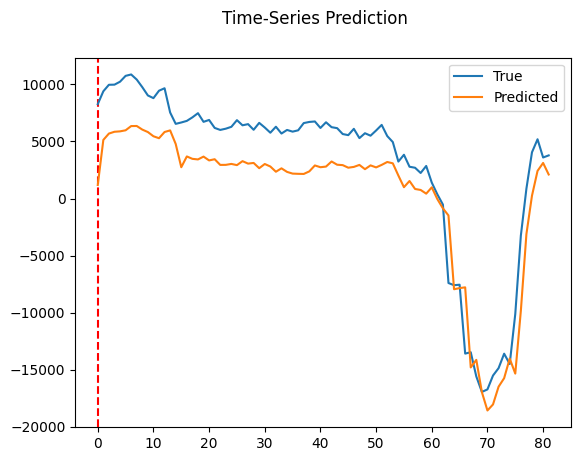

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

# Get the last 144 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit={best_seq * 85 * 2}")
usage = response.json()
ten_minute_averages = {"timestamp": [], "power": [], "isDay": [], "hour": []}
time_format = '%Y-%m-%dT%H:%M:%S.%fZ'
for i in range(0, len(usage['data']), 85):
    values = usage['data'][i:i+120]
    power = [value['power'] for value in values]
    ten_minute_averages["timestamp"].append(values[0]['timestamp'])
    ten_minute_averages["power"].append(np.average(power) * 1000)
    test_date = datetime.datetime.strptime(values[0]['timestamp'], time_format)
    test_date = test_date - datetime.timedelta(hours=6)
    isDay =  1 if test_date.hour >= 7 and test_date.hour <= 19 else 0 # From 7:00 AM to 7 PM is day
    hour = test_date.hour
    ten_minute_averages["isDay"].append(isDay)
    ten_minute_averages["hour"].append(hour)
df = pd.DataFrame(columns=["timestamp", "power", "isDay", "hour"])    
temp_df = pd.DataFrame(ten_minute_averages)
df = pd.concat([df, temp_df], ignore_index=True)
test_training_set = df.iloc[:, 1:5].values

# power = ten_minute_averages["power"]
# power = [[i] for i in power]
# print(len(power))
# power = np.array(power)

test_training_set = sc.fit_transform(test_training_set)
testNewX, testNewY = sliding_windows(test_training_set, best_seq)
testDataX = Variable(torch.Tensor(np.array(testNewX)))
testDataY = Variable(torch.Tensor(np.array(testNewY)))

print(testDataX.shape)

lstm.eval()
test_predict = lstm(testDataX.to(device))

data_predict = test_predict.cpu().data.numpy()
dataY_test_plot = dataY.cpu().data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testDataY)

#Plot the Predictions
plt.axvline(x=0, c='r', linestyle='--')

power = [i[0] for i in dataY_plot]
power_predict = [i[0] for i in data_predict]

plt.plot(power, label="True")
plt.plot(power_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
torch.save(lstm.state_dict(), "energy_usage_predictor_bidirectional.pth")

In [ ]:
# Given a the necessary points, it will try to generate new points to compare to what actually happened.
 